# Neural Net Language Models

In [ ]:
#| default_exp models.lm

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader

import lightning as L
from lightning import Trainer, LightningModule
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.loggers import CSVLogger

from matplotlib import pyplot as plt
# plt.set_loglevel('INFO')
import pandas as pd
from tqdm import tqdm
import pprint

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import List
from dataclasses import dataclass, asdict

from nimrod.text.datasets import CharDataset, Vocab
from nimrod.utils import set_seed, get_device
from nimrod.models.core import Classifier

import logging
logger = logging.getLogger(__name__)


In [ ]:
# N_EPOCHS for training debuggging
ITER_MAX = 1
set_seed(42)

Seed set to 42


In [ ]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

names:  ['emma', 'olivia', 'ava']


## Data formatting
given last n tokens we predict token n+1

In [ ]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [ ]:
# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add sentence tokens
# data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
# data = [list(line.strip()) for line in lines]
data = [list(line) for line in lines]
print("data: ", data[:3])

data:  [['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n'], ['B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n'], ['A', 'l', 'l', ':', '\n']]


In [ ]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


for each row in the dataset we expand all the combinations of ngrams

In [ ]:
v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
print("vocabulary: ", v.vocabulary)
print("vocabulary size: ", len(v))


[21:05:26] INFO - Vocab: read text file


vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '<pad>', '<unk>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocabulary size:  67


In [ ]:
CONTEXT_LEN = 3
X, y = make_dataset(data[:80], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n']
['<pad>', 'F'] i
['<pad>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] 

row:  ['B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n']
['<pad>', 'B'] e
['<pad>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' ', 'a'] n
[' ', 'a', 'n'] y
['a', 'n', 'y']  
['n', 'y', ' '] f
['y', ' ', 'f'] u
[' ', '

## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [ ]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int = 30, # vocabulary size 
                n_emb:int = 10, # embedding dimension
                n_context:int = 3, # context size bigram/trigram, etc.
                n_h:int = 100 # hidden layer size
                ):

        logger.info(f"NNLM: Init")
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)

    @torch.no_grad()
    def sample(self, prompt:str, vocab:Vocab, max_new_tokens:int=50, temperature:float=1.0):

        for _ in range(max_new_tokens):            
            # limit prompt to context size
            context = prompt[-self.n_context:]
            context = vocab.stoi(list(context))

            logits = self(torch.tensor(context))
            logits = logits / temperature
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            prompt += vocab.itos(ix)
        return(prompt)

### Usage

In [ ]:
# config model
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))

# test data
bs = 25
x = torch.randint(conf.n_vocab, (bs, conf.n_context)) # (B, T) with values between 0 and n_vocab
print("X (B, T):", x.shape)

# prediction
y = lm(x)
print("Y_hat logits (B, n_vocab):", y.shape)

[21:05:27] INFO - NNLM: Init


X (B, T): torch.Size([25, 3])
Y_hat logits (B, n_vocab): torch.Size([25, 67])


## Train MLP LM

### handmade dataset

In [ ]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data[:80]))
print("len Xtr: ", len(Xtr))
print("CONTEXT_LEN: ", CONTEXT_LEN)

Xtr (B, T):  torch.Size([2623, 3]) Ytr (B):  torch.Size([2623]) data: 80
len Xtr:  2623
CONTEXT_LEN:  3


#### Overfit on subset of 80 first rows

In [ ]:
#| notest

%time
device = get_device()
device = 'cpu'
# lm.to(device)

# overfit on one big batch
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

[21:05:27] INFO - Using device: mps


CPU times: user 5 μs, sys: 4 μs, total: 9 μs
Wall time: 2.15 μs


  6%|▌         | 59/1000 [00:00<00:01, 588.98it/s]

4.189066410064697


 38%|███▊      | 376/1000 [00:00<00:01, 611.20it/s]

2.6202232837677


 62%|██████▏   | 623/1000 [00:01<00:00, 599.64it/s]

2.3751416206359863


 86%|████████▌ | 860/1000 [00:01<00:00, 535.46it/s]

2.199942111968994


100%|██████████| 1000/1000 [00:01<00:00, 575.01it/s]


[<matplotlib.lines.Line2D>]

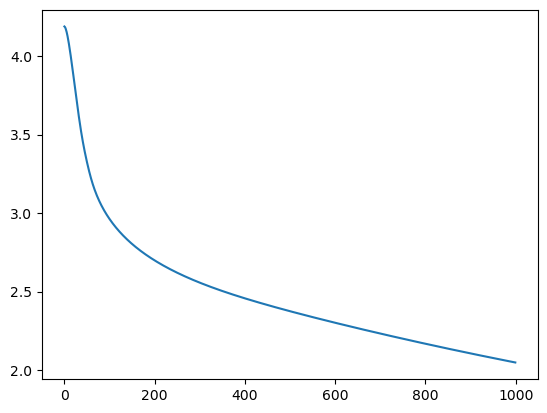

In [ ]:
#| notest
plt.plot(train_loss)

#### Sample

In [ ]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=250, temperature=0.6)
print(sequences)


The country of that Citiz he that ss aer he the the hat yire to den fim to the the bu fh thas you ko gour puicen: cat Citizen:

YYde we pa coond Citizes aft iaizet arr you arat we poor pour, bat peo:
 peap hith hame her to the fat you apithey hiss bou to the so the


### Dataloader

In [ ]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
# use <unk> and <pad> to be consistent with manual data preprocessing and have smae vocabulary size
v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
print("vocabulary: ", v.vocabulary)
print("vocabulary size: ", len(v))
print(cfg)
cfg.train_val_test_split = [0.8, 0.1, 0.1]
# by default data_path is relative to the recipe folder so need to update for nbs
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 2700 # large batch to mimic manual data order of magnitude
cfg.random_split = False
cfg.specials=['<unk>', '<pad>']
cfg.add_sentence_tokens = False
print(cfg)
dm = instantiate(cfg)
dm.setup()
print("vocab size: ", dm.vocab_size)
# setup large batch to overfit / test model
Xtr, Ytr= next(iter(dm.train_dataloader()))
# target is last token in sequence
Ytr = Ytr[:, -1]
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape)
X, Y = dm.train_ds[0]
print(dm.ds.from_tokens(X), dm.ds.from_tokens(Y))


[21:05:29] INFO - Vocab: read text file
[21:05:29] INFO - CharDataModule: init
[21:05:29] INFO - CharDataModule: setup, split datasets
[21:05:29] INFO - CharDataset: init
[21:05:29] INFO - Vocab: read text file
[21:05:29] INFO - Split dataset into train/val/test. Keep sequence order.


vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '<pad>', '<unk>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocabulary size:  67
{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'specials': ['<pad>', '<unk>'], 'add_sentence_tokens': False, 'train_val_test_split': [0.8, 0.1, 0.1], 'random_split': False, 'batch_size': 64, 'context_size': 3, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}
{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'specials': ['<unk>', '<pad>'], 'add_sentence_tokens': False, 'train_val_test_split': [0.8, 0.1, 0.1], 'random_split': False, 'batch_size': 2700, 'context_size': 3, 'num_workers': 0, 'pi

In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
print(len(v), CONTEXT_LEN)
lm = NNLM(**asdict(conf))
bs = 10
x = torch.randint(conf.n_vocab, (bs, conf.n_context)) # (B, T) with values between 0 and n_vocab
print("X (B, T):", x.shape)
lm(x).shape

[21:05:29] INFO - NNLM: Init


67 3
X (B, T): torch.Size([10, 3])


torch.Size([10, 67])

In [ ]:
# checking data tokens are between 0 and vocab size
print(Xtr.min(),  Xtr.max())

tensor(0) tensor(66)


#### overfit 

In [ ]:
#| notest

%time
# device = get_device()
device = 'cpu'
lm.to(device)

# overfit on one big batch
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 14.1 μs


  0%|          | 0/1000 [00:00<?, ?it/s]

4.245690822601318


 32%|███▏      | 315/1000 [00:00<00:01, 632.60it/s]

2.785951852798462


 58%|█████▊    | 584/1000 [00:00<00:00, 658.39it/s]

2.5501415729522705


 88%|████████▊ | 877/1000 [00:01<00:00, 710.10it/s]

2.4038991928100586


100%|██████████| 1000/1000 [00:01<00:00, 660.55it/s]


[<matplotlib.lines.Line2D>]

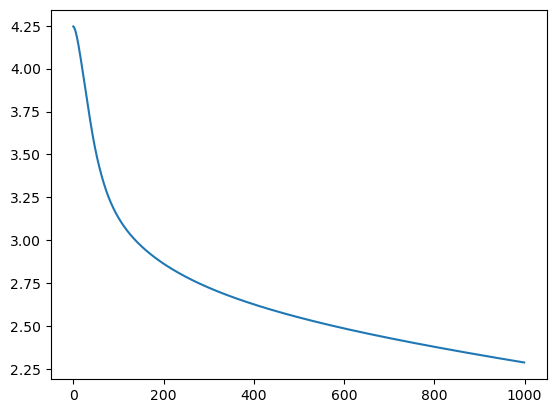

In [ ]:
#| notest
plt.plot(train_loss)

In [ ]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=250, temperature=0.6)
print(sequences)

The country of the er thoR mis thath the en sean en od thath
The Itrer lower wy he forat ime they thands siee s and, in thand and sourus is has that R her bovertho for hat wom tuer hand ny deme tharpit us me the ond Iore forr,aty de chee utrer str and ne tore yode



#### Batching with dataloaders

In [ ]:
# mini batch gradient descent with datamodule
cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.train_val_test_split = [0.8, 0.1, 0.1]
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 2048
cfg.random_split = False
cfg.specials=['<unk>', '<pad>']
cfg.add_sentence_tokens = False
dm = instantiate(cfg)
dm.setup()

conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))


[21:05:31] INFO - CharDataModule: init
[21:05:31] INFO - CharDataModule: setup, split datasets
[21:05:31] INFO - CharDataset: init
[21:05:31] INFO - Vocab: read text file
[21:05:31] INFO - Split dataset into train/val/test. Keep sequence order.
[21:05:31] INFO - NNLM: Init


In [ ]:
#| notest

%time

optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
# device = get_device()
device = 'cpu'
lm.to(device)
i = 0
EPOCHS = 1
for epoch in tqdm(range(EPOCHS)):
    print(f"epoch {epoch}")
    for batch in tqdm(dm.train_dataloader()):
        Xtr, Ytr = batch
        # target is last token in sequence
        Ytr = Ytr[:, -1] # BxT
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        if not(i%1000):
            print(loss.item())
        i += 1

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 μs


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 0


4.255069255828857


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


[<matplotlib.lines.Line2D>]

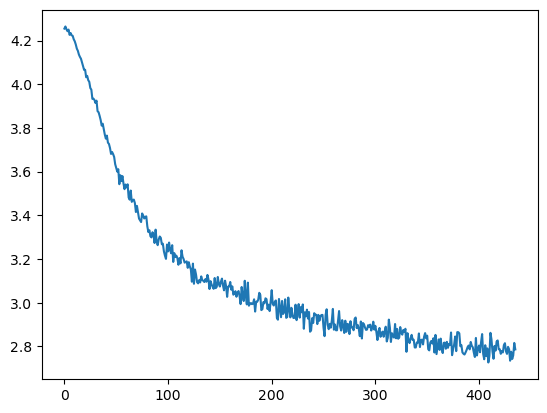

In [ ]:
#| notest
plt.plot(train_loss)

#### Sample

In [ ]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

The country of taana, barN.g! eat th re dae b, lod tend his anc tolize 
arod ong
C FB Sind frmae g,alfre y m-vxfYout lo w



Xht mn is woEhas foroofd ty uhismam the touw ier, wlins erud ig, nougs hit nn worle ay pnrgells hy 
&$, hut sh lis mis unnd
uolem
y the .erersDmater,seylr.
Anns topgovbso nrt oh totlm :umd hadxhe u wow:he bA sep i; lo raa
wouor se th Uho!llpdd?Qugot tousus sa f hI stheris 
oll y, 
a nn  ooltcey cany hQm,vf aurswoua ar, aolnvend hey storg oS ;ins ken oob'chit nf hasoufy brOir. momJ thithe


## MLP LM X Model

In [ ]:
#| export 

class NNLM_X(Classifier, LightningModule):
    def __init__(
            self,
            nnet: NNLM,
            num_classes:int,
            optimizer: torch.optim.Optimizer,
            scheduler: torch.optim.lr_scheduler,
            ):

        logger.info("NNLM_X: Init")
        super().__init__(
            num_classes,
            optimizer,
            scheduler,
            )
        self.save_hyperparameters(logger=False)
        # required attribute for lr finder
        self.lr = optimizer.keywords['lr']
        self.nnet = nnet
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        y = y[:, -1]
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y = y[:, -1]  # Get the last token as target
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)
    
    def sample(self, prompt:str, vocab:Vocab, max_new_tokens:int=50, temperature:float=1.0):
        return self.nnet.sample(prompt, vocab, max_new_tokens, temperature)

### Usage

In [ ]:
# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
cfg.num_classes = len(v)
print(len(v))
# have to convert omegaconf dict to dict for pprint
opt = instantiate(cfg.optimizer)
print(opt.keywords['lr'])

pprint.pprint(dict(cfg))
lm  = instantiate(cfg)
print(lm.hparams.optimizer)

[21:06:10] INFO - NNLM: Init
[21:06:10] INFO - NNLM_X: Init


67
0.001
{'_target_': 'nimrod.models.lm.NNLM_X',
 'nnet': {'_target_': 'nimrod.models.lm.NNLM', 'n_vocab': '${num_classes}', 'n_emb': 10, 'n_context': 3, 'n_h': 100},
 'num_classes': 67,
 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': 0.001, 'weight_decay': 1e-05},
 'scheduler': {'_target_': 'torch.optim.lr_scheduler.ReduceLROnPlateau', '_partial_': True, 'mode': 'min', 'factor': 0.1, 'patience': 10}}


InstantiationException: Error in call to target 'nimrod.models.lm.NNLM_X':
TypeError("Classifier.__init__() missing 1 required positional argument: 'scheduler'")

In [ ]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.nnet.n_context))
print("X:", x.shape)

In [ ]:
y = lm(x)
print("Y_hat logits:", y.shape)

In [ ]:
# v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
lm.sample("The country of ", v, max_new_tokens=500, temperature=0.9)

### L Training Loop

In [ ]:
# vocab
print(len(v))

# data
cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.context_size = CONTEXT_LEN
cfg.specials: ["<pad>", "<unk>"]
cfg.batch_size = 2048
cfg.random_split = False
dm = instantiate(cfg)
dm.setup()

# model
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)

In [ ]:
print(lm.__dict__)


model can be easily trained with L trainer (c.f. recipes/text/ for examples)

In [ ]:
trainer = Trainer(
    accelerator="auto",
    max_epochs=1,
    logger=CSVLogger("logs", name="nnlm")
    )


In [ ]:
#| notest
trainer.fit(lm, dm.train_dataloader(), dm.val_dataloader())

In [ ]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()



In [ ]:
#| notest

plt.plot(metrics['step'], metrics['train/loss_step'],'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.show()

In [ ]:
#| notest
trainer.test(lm, dm.test_dataloader())

In [ ]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

### Learning Rate Finder

In [ ]:
lm.hparams

In [ ]:
#| notest

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=1,
)
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    lm,
    datamodule=dm,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

### re-train with new lr

In [ ]:
#| notest
new_lr = lr_finder.suggestion()
lm.lr = new_lr

In [ ]:
#| notest

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=1,
    logger=CSVLogger("logs", name="nnlm"),
)
trainer.fit(lm, dm.train_dataloader(), dm.val_dataloader())
trainer.test(lm, dm.test_dataloader())


In [ ]:
#| notest

csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
plt.plot(metrics['step'], metrics['train/loss_step'],'.-')
# plt.figure()
# plot_classifier_metrics_from_csv(csv_path)



In [ ]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

## NN Bigram

In [ ]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self._vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
    @property
    def vocab_size(self)->int:
        return self._vocab_size


### Usage

In [ ]:

B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
print("vocab size: ",  model.vocab_size)
X = torch.randint(0,C,(B,T))
Y = torch.randint(0,C,(B,T))
batch = (X,Y)
logits = model(X) # (B, T, C)
print("X: ", X.shape, "Y: ", Y.shape, "logits: ", logits.shape)

In [ ]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

In [ ]:

# #| export
# class NNBigramL(ModelModule):
#     def __init__(self, vocab_size:int, lr:float=1e-3):
#         model = NNBigram(vocab_size)
#         super().__init__(model, lr)
#         self.accuracy = Accuracy(task='multiclass', num_classes=model.vocab_size)

#     def _step(self, batch:torch.tensor, batch_idx:int):
#         x, y = batch
#         logits = self.model(x) # (B,T,C)
#         B, T, C = logits.shape
#         logits = logits.view(B*T, C)
#         y = y.view(B*T)
#         loss = self.loss(logits, y)
#         acc = self.accuracy(logits, y)
#         return loss, acc
    
#     def predict(self,idx:torch.IntTensor, max_new_tokens:int):
#         return self.model.predict(idx, max_new_tokens)

In [ ]:
# model_pl = NNBigramL(vocab_size)
# logits = model_pl(X) # (B, T, C)
# print(logits.shape)
# model_pl.training_step(batch, 0)
# model_pl._step(batch, 0)
     

### Data

In [ ]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [ ]:
# dataset
block_size = 8
ds = CharDataset(data_path='../data/text/tiny_shakespeare.txt', context_length=block_size)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

In [ ]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

### Training

In [ ]:
model = NNBigram(ds.vocab_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [ ]:
#| notest
%time
ITER_MAX = 1000
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

In [ ]:
#| notest
plt.plot(train_loss)

In [ ]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

## training from module

In [ ]:
# %%time
# n_epochs = 1
# train_loss = []
# for epoch in range(n_epochs):
#     model_pl.model.train()
#     loss = model_pl.training_step(batch, None)
#     loss.backward()
#     optimizer.step()
#     train_loss.append(loss.item())
#     if not(epoch % 100):
#         print(loss.item())
     


In [ ]:
# print(ds.from_tokens(model_pl.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()